#### Template

*This Notebook is part of a Github Repository Template defining a Project File Structure. (See README.md)*

```.
├── config.yaml
├── data
│   └── README_data.md
├── environment.yaml
├── README.md
├── scripts
│   ├── clean.sh
│   ├── downsample.sh
│   ├── generate_reference.sh
│   ├── nb2py.sh
│   ├── README_scripts.md
│   └── run_ubs_seq.sh
├── src
│   └── README_IGV_WEB.md
└── workspace
    ├── README_workspace.md
    ├── ubs_basic.ipynb
    └── ubs_basic.py
```

# UBS-seq Pipeline
## Basic Workflow

**C. Bryan Daniels**

**3/1/2024**

## Project: UBS-seq Basic Pipeline

The purpose of this project is run a minimally viable UBS-seq pipline. For simplicity, it will run several single-end samples, mapping only to the genome. The core steps of the pipeline are:
- cut_apapter
- quality_control
- align2ref
- sort2ref
- dedupe
- filter->all_multi_unique
- call_peaks
- select_groups
- analysis_and_annotation

This pipeline is based upon the paper by [Qing Dai, etal](https://doi.org/10.1038/s41587-023-02034-w) and the UBS-seq pipeline developed by [Chang Ye](https://github.com/y9c/m5C-UBSseq)



## Setup

#### The logic for the Pipeline is defined through a series of Steps using dirs to save intermediate results
1. For each **Step** in the pipeline a dir will be created and labeled **Step** and will contain all files created by that **Step**
2. Within a **Step**, **in_path** and **out_path** will generically refer to the prior and current **Step**
3. Within each **Step**, the appropriate processes will occur. Generally this involves processing files from **in_path** and saving to **out_path**
4. **Abbreviated filenames** should not change through the pipeline (suffixes will reflect current file formats). The dir name should reflect the **Step**, not the filename.
6. The function **mkpath(step)** returns a path for a dir **Step**. It will create a dir if need be, but not overwrite an existing dir
8. The function **fname(path,sample,suffix)** returns a file name without actually creating the file

#### Convert Notebook to Script to Execute from the Command Line

```
# cd workplace/
# juptyer nbconvert ubs_basic.ipynb --to script
# ipython ubs_basic.py
```

### Environment

In [1]:
import os, sys, subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from pathlib import Path
from IPython.display import display, HTML
from snakemake import load_configfile
from operator import itemgetter as items

In [2]:
home_path      = Path.cwd()/'..'
workspace_path = home_path/'workspace'

In [3]:
os.environ['PATH'] = f"{str(home_path)}:" + os.environ['PATH'] # home_path
os.environ['PATH'] = '/home/cdaniels/bin/homer:' + os.environ['PATH'] # homer
os.environ['PATH'] = '/home/cdaniels/bin/hisat-3n:' + os.environ['PATH'] # hisat-3n
os.environ['_JAVA_OPTIONS'] = '-Xmx8g' # Set Java Flag

In [4]:
nc = get_ipython().getoutput('nproc') # Number of cores  
nc = int(nc[0]); nc

32

### Functions

In [9]:
sys.path.append(f"{home_path}/scripts/") # scripts/

from configure import * 
from utils import *
from fnames import * 

In [12]:
from importlib import reload
import configure, utils, fnames
reload(configure); reload(utils);reload(fnames);
from configure import *
from utils import *
from fnames import *

In [13]:
fname?

Signature: fname(path, stem, suffix, tail='')
Docstring:
fname :: str  -> str -> str -> Path
fname :: Path -> str -> str -> Path

Return a new Path comprised of a `path`, `stem` and `suffix`
`tail` appends str to end of stem. Default: tail=''

Example:
fname(in_path, 't1_r1', 'bam')          -> Path('some_path/t1_r1.bam)
fname(in_path, 't1_r1', 'bam', 'genes') -> Path('some_path/t1_r1_genes.bam)
File:      ~/uofc_data/ubs_seq/UBS-seq_basic/scripts/fnames.py
Type:      function

In [7]:
mkpath?

Signature: mkpath(path)
Docstring:
mkpath :: str -> IO Path

Creates and returns (not over-writting) a new dir `path`. The current date/time is sent to stdout.

Example:
mkpath('dir_name') -> Path('some_path') and new dir `dir_name`
File:      ~/uofc_data/ubs_seq/UBS-seq_basic/scripts/fnames.py
Type:      function

In [8]:
samples?

Signature: samples(n=2, end='se', extra=[])
Docstring:
samples :: Int -> Bool -> [String] ->
Generates iterators of sample names as defined in 'sample2data'
- n=1 returns an iterator of biological replicates, sample(2) -> ['t1', 't2', 'c1']
- n=2 (default) returns an iterator of biologial replicates and runs -> ['t1_r1', 't2_r1', 'c1_r1']
- end='se' (default) filters for SE reads, end='pe' filters for PE reads, end='all' returns all as a FLAT list.
- extra=[alist] returns an iterator which is the Cartesian product of the elements of alist and the original iterator

Example:
samples(end='se',extra=['gene','genome']) ->
 [('t1', 'r1', 'gene'), ('t1', 'r1', 'genome'), ('t2', 'r1', 'gene'), ('t2', 'r1', 'genome'), ('c1', 'r1', 'gene'), ('c1', 'r1', 'genome')]
File:      ~/uofc_data/ubs_seq/UBS-seq_basic/scripts/configure.py
Type:      function

In [9]:
data?

Signature: data(end='se')
Docstring:
data :: Bool -> [(String, Path)]
Generates iterator of data paths as defined in `sample2list`
- type='SE' will filter for SE -> [(key1, Path(R1)) ...]
- type='PE' will filter for PE -> [(key11, Path(R1)),(key12, Path(R2)) ...]

Example:
data() -> [('t1_r1', PosixPath('../data/test1_R1.fq.gz')),
           ('t2_r1', PosixPath('../data/test2_R1.fq.gz')),
           ('c1_r1', PosixPath('../data/test3_R1.fq.gz'))]

data(end='pe') ->
          [(('t2_r1_R1', PosixPath('../data/SRR23538294_1.fq.gz')),
            ('t2_r1_R2',PosixPath('../data/SRR23538294_2.fq.gz'))),
           (('t2_r2_R1',PosixPath('../data/SRR23538293_1.fq.gz')),
            ('t2_r2_R2', PosixPath('../data/SRR23538293_2.fq.gz')))]
File:      ~/uofc_data/ubs_seq/UBS-seq_basic/scripts/configure.py
Type:      function

In [10]:
fnames?

Signature: fnames(dir_or_files, suffix='', key='stem')
Docstring:
fnames :: str      -> str -> str -> [str]
fnames :: Path     -> str -> str -> [str]
fnames :: [str]    -> str -> str -> [str]
fnames :: Iterator -> str -> str -> [str]

Returns a list of filenames
`dir_or_files` can be: a string or Path name of a dir; a list of file names; an Iterator of file names.
`suffix` is a string by which to filter files, returning only those ending in .`suffix`
`key` specifies which value of `fname_index(f)` is returned for each file name. Example use of `key`
    fname_index('map_se/t1_r1_genes.bam') ->
        'full':   map_se/t1_r1_genes.bam
        'path':   map_se
        'name':   t1_r1_genes.bam
        'stem':   t1_r1_genes
        'suffix': bam
        'keys':   ['t1', 'r1', 'genes']

Examples:
fnames('map_se') ->
    ['map_se/t1_r1_genome.summary', 'map_se/t1_r1_genes.bam.csi', 'map_se/t1_r2_genome.bam', ...]
fnames('map_se', 'bam') ->
    ['map_se/t1_r2_genome.bam', 'map_se/t1_r2_genes

In [11]:
fname_index?

Signature: fname_index(path_or_file)
Docstring:
fname_index :: str -> dict
fname_index :: Path -> dict

Returns a dict of a file name split by keys=['full', 'path', 'name', 'stem', 'suffix', 'keys'])
`path_or_file is a string or Path file name`

Example:
    fname_index('map_se/t1_r1_genes.bam') ->
        'full':   map_se/t1_r1_genes.bam
        'path':   map_se
        'name':   t1_r1_genes.bam
        'stem':   t1_r1_genes
        'suffix': bam
        'keys':   ['t1', 'r1', 'genes']
File:      ~/uofc_data/ubs_seq/UBS-seq_basic/scripts/fnames.py
Type:      function

In [12]:
fname_split?

Object `fname_split` not found.


In [13]:
fnames_match?

Signature: fnames_match(files, pattern, **wildcards)
Docstring:
fname_match :: [str] -> str -> [(str, [str])] -> [[str]]
Returns a list of list of files matching the pattern.

`files` is a list of file names
`pattern` is a string similiar to the target `files` with each wildcard indicated by `{ }`
`pattern` will generally hava a form: {sample}_{run}_{pair}_{ref}.{ext}, though order
does not matter. Names do not matter provided they correspond to the names used in
wildcard named lists.
`**wilcards` are named lists, where the wildcard name is used within the pattern
For example: sample = ['t1','c1']

When files are matched to a pattern, chars between two {wildcard} will be ignored.
This allows grouping of matched files, which are returned as a list

Example:
files =['t1_1_genes.bam', 't1_r2_genes.bam', 't1_r1_genome.bam', 't1_r2_genome.bam',
        'c1_r1_genes.bam', 'c1_r1_genome.bam']

match_files(files, "{sample}_{ref}.bam", sample = ['t1','c1'], ref = ['genes','genome']) ->

    [['

### Configuration file

Use `config.yaml` to configure `references/` and `samples`

In [14]:
config = load_configfile(home_path/"config.yaml")

`refs` are the types of mapping used and as defined in `config.yaml`

In [15]:
refs = ['genes','genome']

`get_ref()` returns the path (partially defined in `config.yaml`) for a `ref` of type `fasta` or `index`: `[ref][type]`

In [16]:
def get_ref(ref,type): return home_path/config['reference'][ref][type]

In [17]:
# Not strictly needed, better to use get_ref() directly
genome_fa  = get_ref('genome','fa')
genome_idx = get_ref('genome','hisat3n')
genes_fa   = get_ref('genes','fa')
genes_idx  = get_ref('genes','hisat3n')

## Step: select_samples

#### Define sample names and link to sample files

In [18]:
out_path = mkpath('select_samples')

>>> {select_samples} 17:26:43_03-24-2024


Samples were obtained from NCBI using the SRR ID

| ID | Run | Strand | Group   | SRR           | Description                                               | Species |                                 
|:---|-----|--------|---------|---------------|-----------------------------------------------------------|---------|                                 
| t1 | r1  | R1     | Treated | SRR23538292   | WT HeLa polyA+ RNA treated with ultrafast BS, replicate 1 | Human   |                                 
| t1 | r2  | R1     | Treated | SRR23538291   | WT HeLa polyA+ RNA treated with ultrafast BS, replicate 2 | Human   |                                 
| t2 | r1  | R1     | Treated | SRR23538294_1 | 7ng of cfDNA treated with ultrafast BS, replicate 1       | Human   |                                 
| t2 | r1  | R2     | Treated | SRR23538294_2 | 7ng of cfDNA treated with ultrafast BS, replicate 1       | Human   |                                 
| t2 | r2  | R1     | Treated | SRR23538293_1 | 7ng of cfDNA treated with ultrafast BS, replicate 2       | Human   |                                 
| t2 | r2  | R2     | Treated | SRR23538293_2 | 7ng of cfDNA treated with ultrafast BS, replicate 2       | Human   |                                 
| c1 | r1  | R1     | Control | SRR23538290   | WT HeLa polyA+ RNA treated with ultrafast BS, replicate 3 | Human   |

In [19]:
samples(1)

['t1', 't2', 'c1']

In [20]:
samples(2,end='se')

['t1_r1', 't1_r2', 'c1_r1']

In [21]:
samples(2,end='pe')

[('t2_r1_R1', 't2_r1_R2'), ('t2_r2_R1', 't2_r2_R2')]

In [22]:
samples(end='all')

['t1_r1', 't1_r2', 'c1_r1', 't2_r1_R1', 't2_r1_R2', 't2_r2_R1', 't2_r2_R2']

##### Sample Groups and Labels

In [71]:
# Biological Samples
bio_samples = samples(1)
# Experimental Samples
treated, control = group2run['treated'], group2run['control']
# Sequence Samples (Only PE are indicated)
treated_data,control_data = group2data['treated'], group2data['control']
print(f'bio_samples = {bio_samples}')
print(f'treated = {treated}')
print(f'control = {control}')
print(f'treated_data = {treated_data}')
print(f'control_data = {control_data}')

bio_samples = ['t1', 't2', 'c1']
treated = ['t1_r1', 't1_r2', 't2_r1', 't2_r2']
control = ['c1_r1']
treated_data = ['t1_r1', 't1_r2', 't2_r1_R1', 't2_r1_R2', 't2_r2_R1', 't2_r2_R2']
control_data = ['c1_r1']


##### Samples linked to Data Files

Symbolically link short names with sample files

In [29]:
data(end='se')

[('t1_r1',
  PosixPath('/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/SRR23538292.fq.gz')),
 ('t1_r2',
  PosixPath('/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/SRR23538291.fq.gz')),
 ('c1_r1',
  PosixPath('/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/SRR23538290.fq.gz'))]

In [30]:
data(end='pe')

[('t2_r1_R1',
  PosixPath('/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/SRR23538294_1.fq.gz')),
 ('t2_r1_R2',
  PosixPath('/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/SRR23538294_2.fq.gz')),
 ('t2_r2_R1',
  PosixPath('/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/SRR23538293_1.fq.gz')),
 ('t2_r2_R2',
  PosixPath('/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/SRR23538293_2.fq.gz'))]

`end='all'` flattens PE in order to concatenate with SE

In [26]:
data(end='all')

[('t1_r1',
  PosixPath('/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/SRR23538292.fq.gz')),
 ('t1_r2',
  PosixPath('/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/SRR23538291.fq.gz')),
 ('c1_r1',
  PosixPath('/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/SRR23538290.fq.gz')),
 ('t2_r1_R1',
  PosixPath('/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/SRR23538294_1.fq.gz')),
 ('t2_r1_R2',
  PosixPath('/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/SRR23538294_2.fq.gz')),
 ('t2_r2_R1',
  PosixPath('/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/SRR23538293_1.fq.gz')),
 ('t2_r2_R2',
  PosixPath('/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/SRR23538293_2.fq.gz'))]

In [31]:
for (s,fn) in data(end='all'):
    !ln -s {fn} {fname(out_path,s,"fq.gz")}

ln: failed to create symbolic link 'select_samples/t1_r1.fq.gz': File exists
ln: failed to create symbolic link 'select_samples/t1_r2.fq.gz': File exists
ln: failed to create symbolic link 'select_samples/c1_r1.fq.gz': File exists
ln: failed to create symbolic link 'select_samples/t2_r1_R1.fq.gz': File exists
ln: failed to create symbolic link 'select_samples/t2_r1_R2.fq.gz': File exists
ln: failed to create symbolic link 'select_samples/t2_r2_R1.fq.gz': File exists
ln: failed to create symbolic link 'select_samples/t2_r2_R2.fq.gz': File exists


Check that the files look correct

In [32]:
!ls -lLh {out_path}

total 736M
-rw-rw-r-- 1 cdaniels cdaniels  37M Mar 21 14:36 c1_r1.fq.gz
-rw-rw-r-- 1 cdaniels cdaniels  47M Mar 21 14:36 t1_r1.fq.gz
-rw-rw-r-- 1 cdaniels cdaniels  49M Mar 21 14:36 t1_r2.fq.gz
-rw-rw-r-- 1 cdaniels cdaniels 146M Mar 21 14:37 t2_r1_R1.fq.gz
-rw-rw-r-- 1 cdaniels cdaniels 163M Mar 21 14:37 t2_r1_R2.fq.gz
-rw-rw-r-- 1 cdaniels cdaniels 140M Mar 21 14:37 t2_r2_R1.fq.gz
-rw-rw-r-- 1 cdaniels cdaniels 158M Mar 21 14:37 t2_r2_R2.fq.gz


How many sequence reads do we have per Sample

In [33]:
# Total Reads per Samples
for sample in samples(end='all'):
    !echo {sample}: `samtools view -c {fname(out_path, sample, 'fq.gz')}`

t1_r1: 1183321
t1_r2: 1365245
c1_r1: 935632
t2_r1_R1: 2411940
t2_r1_R2: 2411940
t2_r2_R1: 2423332
t2_r2_R2: 2423332


## Step: fastqc_pre

#### Pre Trimming Quality Control

In [36]:
in_path = mkpath("select_samples")
out_path = mkpath("fastqc_pre")

>>> {select_samples} 18:06:43_03-24-2024
>>> {fastqc_pre} 18:06:43_03-24-2024


#### fastqc

In [22]:
#! fastqc --help

##### paramaters:
- -o output dir

In [38]:
for sample in samples(end='all'):
    ! fastqc {fname(in_path,sample,"fq.gz")} -o {out_path} 2> /dev/null

application/gzip
Analysis complete for t1_r1.fq.gz
application/gzip
Analysis complete for t1_r2.fq.gz
application/gzip
Analysis complete for c1_r1.fq.gz
application/gzip
Analysis complete for t2_r1_R1.fq.gz
application/gzip
Analysis complete for t2_r1_R2.fq.gz
application/gzip
Analysis complete for t2_r2_R1.fq.gz
application/gzip
Analysis complete for t2_r2_R2.fq.gz


In [39]:
! ls {out_path}

c1_r1_fastqc.html  t1_r2_fastqc.zip	 t2_r2_R1_fastqc.html
c1_r1_fastqc.zip   t2_r1_R1_fastqc.html  t2_r2_R1_fastqc.zip
t1_r1_fastqc.html  t2_r1_R1_fastqc.zip	 t2_r2_R2_fastqc.html
t1_r1_fastqc.zip   t2_r1_R2_fastqc.html  t2_r2_R2_fastqc.zip
t1_r2_fastqc.html  t2_r1_R2_fastqc.zip


## Step: trim

#### Trim the adapter and downstream sequence as well as trimmng lower quality downstream sequence

In [40]:
in_path = mkpath("select_samples")
out_path = mkpath("trim")

>>> {select_samples} 18:08:08_03-24-2024
>>> {trim} 18:08:08_03-24-2024


![adapter](../img/adapter.png)

The adapter sequence contains the i7 primer + i7 index + p7 sequence, and all of them can be sequenced in the R1, if the insert fragment is too short. The reason that RNA seq library shows index at the end, and UBS-seq shows index within the sequence, is because UBS-seq library are too short and PE150 sequencing mode can read though the whole index.

Q: Where is barcode3?

In [41]:
adapter =  "AGATCGGAAGAGCACACGTCT" # adapter == rc(adapter)
barcode3 = "ATCACG"

In [59]:
!ls {in_path}

c1_r1.fq.gz  t1_r2.fq.gz     t2_r1_R2.fq.gz  t2_r2_R2.fq.gz
t1_r1.fq.gz  t2_r1_R1.fq.gz  t2_r2_R1.fq.gz


#### cutadapt

In [29]:
#! cutadapt --help

```
cutadapt -j {threads} 
            -n 2 
            -a "{params.barcode3}{params.adapter3};e=0.15;o=6;anywhere;" 
            --untrimmed-output={output.fastq_untrimmed} 
            -o - {input} 2>{output.report1} | 
cutadapt -j {threads} 
            -u 5 -u -5 
            --rename='{{id}}_{{cut_prefix}}{{cut_suffix}} {{comment}}' 
            --max-n=0 
            -q 15 
            --nextseq-trim=15 
            -m 20 
            --too-short-output={output.fastq_tooshort} 
            -o {output.fastq_cut} - >{output.report2}
```

https://cutadapt.readthedocs.io/en/stable/guide.html

##### paramaters:
- -j 0, Number of CPU. Use 0 to autodetect
- --nextseq-trim=15, is used to trim these low-quality tails of 'G's by introducing a variable quality threshold
- --action=trim, trim adapter and downstream sequence
- -a '{barcode3}{adapter};e=0.15;o=6;anywhere;', 
- -n 2, Remove up to COUNT adapters from each read. Default: 1
- -u 5 -u -5, Remove LEN bases from each read. If positve, from beginning. If negative, from end
- --max-n=0, Discard reads with more than COUNT 'N' bases (here any)
- -q 15, Trim low-quality bases from 5' end of eachread before adapter removal.
- -m 20, Discard reads shorter than LEN
- --rename='{{id}}_{{cut_prefix}}{{cut_suffix}} {{comment}}', rename comment of fastq record
- --too-short-output={fname(out_path,sample,"fastq_tooshort")},
- -o {fname(out_path,sample,"fq.gz")}, output file
{fname(in_path,sample,"fq.gz")}, input file

**NOTE:** Added `--length 30` to cutoff reads where C begin to become more common. Not in original code

In [38]:
for sample in samples(end='se'):
    !cutadapt -j 0 -n 2 \
        -a '{barcode3}{adapter};e=0.15;o=6;anywhere;' \
        --untrimmed-output={fname(out_path,sample,'untrimmed')} \
        -o {fname(out_path,sample,'tmp')}\
        {fname(in_path,sample,'fq.gz')} > {fname (out_path,sample,'report1')} 
    
    !cutadapt -j 0 -u 5 -u -5 --max-n=0 -q 15 -m 20 --length 80 --nextseq-trim=15 \
            --rename='{{id}}_{{cut_prefix}}{{cut_suffix}} {{comment}}'\
            --too-short-output={fname(out_path,sample,'tooshort')} \
            -o {fname(out_path,sample,"fq.gz")} \
            {fname(out_path,sample,'tmp')} > {fname(out_path,sample,'report2')}
    
    !rm {fname(out_path,sample,'tmp')}

Done           00:00:01     1,183,321 reads @   0.9 µs/read;  66.70 M reads/minute
Done           00:00:01     1,158,613 reads @   1.1 µs/read;  55.83 M reads/minute
Done           00:00:01     1,365,245 reads @   0.9 µs/read;  69.48 M reads/minute
Done           00:00:01     1,335,535 reads @   1.0 µs/read;  58.59 M reads/minute
Done           00:00:00       935,632 reads @   1.0 µs/read;  62.51 M reads/minute
Done           00:00:01       910,046 reads @   1.2 µs/read;  51.94 M reads/minute


In [42]:
!ls {in_path}

c1_r1.fq.gz  t1_r2.fq.gz     t2_r1_R2.fq.gz  t2_r2_R2.fq.gz
t1_r1.fq.gz  t2_r1_R1.fq.gz  t2_r2_R1.fq.gz


In [43]:
!ls {out_path}

c1_r1.fq.gz	c1_r1.untrimmed  t1_r1.tooshort   t1_r2.report2
c1_r1.report1	t1_r1.fq.gz	 t1_r1.untrimmed  t1_r2.tooshort
c1_r1.report2	t1_r1.report1	 t1_r2.fq.gz	  t1_r2.untrimmed
c1_r1.tooshort	t1_r1.report2	 t1_r2.report1


#### Analysis

Take a look at a FASTQ file

In [79]:
in_fn  = fname(in_path,treated_data[0],'fq.gz')
out_fn = fname(out_path,treated_data[0],'fq.gz')
print(f'in_fn  = {in_fn}')
print(f'out_fn = {out_fn}')

in_fn  = select_samples/t1_r1.fq.gz
out_fn = trim/t1_r1.fq.gz


In [60]:
!ls {in_path}

c1_r1.fq.gz  t1_r2.fq.gz     t2_r1_R2.fq.gz  t2_r2_R2.fq.gz
t1_r1.fq.gz  t2_r1_R1.fq.gz  t2_r2_R1.fq.gz


In [80]:
! zcat {in_fn}|head -16

@SRR23538292.50 50 length=121
ATTTTTGGTTGATTTTGTTAGTAGTATATGTTTGTTTTAAAGATTAAGTTATGTATGTTTAAGTATGTACATCAATCACGAGATCGGAAGAGCACACGTCTGAACTCCAATCACCACCGGA
+
FF:,FFFFFFFFFFFF:FFFFFFFFF:FFFFFFFF,FFFF:FFFFFF::F,,:FF:FFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFFFF:FFFFFFFF:F
@SRR23538292.144 144 length=121
TTTGGAAGAAAGGATTTTGTTAATTTTTTTTCGTATATCACGAGATCTGAATAGCACACGTCTGAACTCCAGTCACCACCGGATCTCGGATGCCGTATTCTGCTTGAAAAATTGGGGGGGG
+
FFFFF:FFFFFF::FFFFFFFFFFFFFFF:FFFFFFFFFFF,F,FFF,,FFFF,FFFFF:F::FFF,FFFF:FFFFFFFFFFFFF::,,,F,,F,:,FF::F,:F:,FF,:,,:,FFFFF,
@SRR23538292.276 276 length=121
TAACTTGGGGTTAGAAGGTGATTTATTTTTTTTTTTTATAAAAAAAAAAAAAAAAAAAAAAAAAAAAGTAAAAAAACGAAAAACGAAAAACACAACTAAGAAAAACAATCAACACCCGAAA
+
FFFFF,:,FFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF,,,::FF:F,,,::,:,,,F:,,:F,,:,,,,,:F,:FF,,,,,,F,:FF,::,
@SRR23538292.379 379 length=121
GGTATGAAGATATTTTGGATGATTGATTGTAAAATCTATCACGAGATCGGAAGAGCACACGTCTGAACTCCAGTCACCACCGGATCTCGTATGCCGTCTTCTGCTTGTAAAATCGGGGGGG
+
FFFFFFFFFFFF

In [81]:
def show_adapter(reads):
    for read in reads.split('\n'):
        read = read.replace(adapter, f'<span style="color: blue;">{barcode3}{adapter}</span>')
        #read = read.replace(adapter, f'<span style="color: blue;">{adapter}</span>')
        display(HTML(read))

Look for adapter in untrimmed reads

In [82]:
reads = ! zcat {in_fn} | head -36  | seqtk seq -A |grep -v '>'
reads = ('\n').join(reads)
show_adapter(reads)

Verify that adapters and all downstream elements of reads have been trimmed

In [83]:
reads = !zcat {out_fn}| head -36  | seqtk seq -A |grep -v '>'
reads = ('\n').join(reads)
show_adapter(reads)

In [49]:
!ls {out_path}

c1_r1.fq.gz	c1_r1.untrimmed  t1_r1.tooshort   t1_r2.report2
c1_r1.report1	t1_r1.fq.gz	 t1_r1.untrimmed  t1_r2.tooshort
c1_r1.report2	t1_r1.report1	 t1_r2.fq.gz	  t1_r2.untrimmed
c1_r1.tooshort	t1_r1.report2	 t1_r2.report1


What did `--rename='{{id}}_{{cut_prefix}}{{cut_suffix}} {{comment}}'` do?

It appears to has included in the fastq header, an id comprised of the first and last 5 nt cut by `-u 5` and `-u -5`

In [50]:
! zcat {in_fn}|head -2  

@SRR23538292.50 50 length=121
ATTTTTGGTTGATTTTGTTAGTAGTATATGTTTGTTTTAAAGATTAAGTTATGTATGTTTAAGTATGTACATCAATCACGAGATCGGAAGAGCACACGTCTGAACTCCAATCACCACCGGA

gzip: stdout: Broken pipe


In [51]:
!zcat {out_fn}| head -2

@SRR23538292.50_ATTTTCATCA 50 length=121
TGGTTGATTTTGTTAGTAGTATATGTTTGTTTTAAAGATTAAGTTATGTATGTTTAAGTATGTA

gzip: stdout: Broken pipe


In [158]:
ad_R1, bar_R1 = 'AGATCGGAAGAGCACACGTCT', 'ATCACG'
ad_R2, bar_R2 = 'AGATCGGAAGAGCGTCGTGT', 'CGTGAT'
# ad_R1 ~= rc(ad_R2) 

print('Singe End: Search for Adapters')
print('--------------------------------------------------------------------------')
for r in samples(end='se'):
    fn = fname(in_path,r,'fq.gz')
    n_ad_R1   = ! zcat -c {fn} | grep {ad_R1} | wc -l
    n_ad_R2   = ! zcat -c {fn} | grep {ad_R2} | wc -l
    total      = ! zcat -c {fn} | wc -l
    n_ad_R1, n_ad_R2, total = int(n_ad_R1[0]), int(n_ad_R2[0]), int(total[0])
    print(f'{r}: n_ad_R1 = {n_ad_R1}, n_ad_R2 = {n_ad_R2}, total = {total}, max_perct = {100*round(max(n_ad_R1,n_ad_R2)/total,4)}')
    print('--------------------------------------------------------------------------')

Singe End: Search for Adapters
--------------------------------------------------------------------------
t1_r1: n_ad_R1 = 1099696, n_ad_R2 = 0, total = 4733284, max_perct = 23.23
--------------------------------------------------------------------------
t1_r2: n_ad_R1 = 1270967, n_ad_R2 = 0, total = 5460980, max_perct = 23.27
--------------------------------------------------------------------------
c1_r1: n_ad_R1 = 859745, n_ad_R2 = 0, total = 3742528, max_perct = 22.97
--------------------------------------------------------------------------


In [155]:
ad_R1, bar_R1 = 'AGATCGGAAGAGCACACGTCT', 'ATCACG'
ad_R2, bar_R2 = 'AGATCGGAAGAGCGTCGTGT',  'CGTGAT'
# ad_R1 ~= rc(ad_R2) 

print('Single End: Search for Bar Codes')
print('----------------------------------------------------------------------------------')
for r in samples(end='se'):
    fn = fname(in_path,r,'fq.gz')
    n_bar_R1   = ! zcat -c {fn} | grep {bar_R1} | wc -l
    n_bar_R2   = ! zcat -c {fn} | grep {bar_R2} | wc -l
    total      = ! zcat -c {fn} | wc -l
    n_bar_R1, n_bar_R2, total = int(n_bar_R1[0]), int(n_bar_R2[0]), int(total[0])
    print(f'{r}: n_bar_R1 = {n_bar_R1}, n_bar_R2 = {n_bar_R2}, total = {total}, max_perct = {round(100*max(n_bar_R1,n_bar_R2)/total,4)}')
    print('----------------------------------------------------------------------------------')

Single End: Search for Bar Codes
----------------------------------------------------------------------------------
t1_r1: n_bar_R1 = 1127609, n_bar_R2 = 4232, total = 4733284, max_perct = 23.823
----------------------------------------------------------------------------------
t1_r2: n_bar_R1 = 1300174, n_bar_R2 = 4760, total = 5460980, max_perct = 23.8084
----------------------------------------------------------------------------------
c1_r1: n_bar_R1 = 886190, n_bar_R2 = 3317, total = 3742528, max_perct = 23.6789
----------------------------------------------------------------------------------


In [157]:
ad_R1, bar_R1 = 'AGATCGGAAGAGCACACGTCT', 'ATCACG'
ad_R2, bar_R2 = 'AGATCGGAAGAGCGTCGTGT', 'CGTGAT'
# ad_R1 ~= rc(ad_R2) 

print('Paired End: Search for Adapters')
print('------------------------------------------------------------------------------')
for r in (rs for sample in samples(end='pe') for rs in sample):
    fn = fname(in_path,r,'fq.gz')
    n_ad_R1   = ! zcat -c {fn} | grep {ad_R1} | wc -l
    n_ad_R2   = ! zcat -c {fn} | grep {ad_R2} | wc -l
    total      = ! zcat -c {fn} | wc -l
    n_ad_R1, n_ad_R2, total = int(n_ad_R1[0]), int(n_ad_R2[0]), int(total[0])
    print(f'{r}: n_ad_R1 = {n_ad_R1}, n_ad_R2 = {n_ad_R2}, total = {total}, max_perct = {round(100*max(n_ad_R1,n_ad_R2)/total,4)}')
    print('------------------------------------------------------------------------------')

Paired End: Search for Adapters
------------------------------------------------------------------------------
t2_r1_R1: n_ad_R1 = 933773, n_ad_R2 = 0, total = 9647760, max_perct = 9.6787
------------------------------------------------------------------------------
t2_r1_R2: n_ad_R1 = 0, n_ad_R2 = 800831, total = 9647760, max_perct = 8.3007
------------------------------------------------------------------------------
t2_r2_R1: n_ad_R1 = 1098520, n_ad_R2 = 1, total = 9693328, max_perct = 11.3327
------------------------------------------------------------------------------
t2_r2_R2: n_ad_R1 = 4, n_ad_R2 = 925804, total = 9693328, max_perct = 9.5509
------------------------------------------------------------------------------


In [156]:
ad_R1, bar_R1 = 'AGATCGGAAGAGCACACGTCT', 'ATCACG'
ad_R2, bar_R2 = 'AGATCGGAAGAGCGTCGTGT',  'CGTGAT'
# ad_R1 ~= rc(ad_R2) 

print('Paired End: Search for Bar Codes')
print('----------------------------------------------------------------------------------')
for r in (rs for sample in samples(end='pe') for rs in sample):
    fn = fname(in_path,r,'fq.gz')
    n_bar_R1   = ! zcat -c {fn} | grep {bar_R1} | wc -l
    n_bar_R2   = ! zcat -c {fn} | grep {bar_R2} | wc -l
    total      = ! zcat -c {fn} | wc -l
    n_bar_R1, n_bar_R2, total = int(n_bar_R1[0]), int(n_bar_R2[0]), int(total[0])
    print(f'{r}: n_bar_R1 = {n_bar_R1}, n_bar_R2 = {n_bar_R2}, total = {total}, max_perct = {round(100*max(n_bar_R1,n_bar_R2)/total,4)}')
    print('----------------------------------------------------------------------------------')

Paired End: Search for Bar Codes
----------------------------------------------------------------------------------
t2_r1_R1: n_bar_R1 = 876, n_bar_R2 = 28922, total = 9647760, max_perct = 0.2998
----------------------------------------------------------------------------------
t2_r1_R2: n_bar_R1 = 36699, n_bar_R2 = 782, total = 9647760, max_perct = 0.3804
----------------------------------------------------------------------------------
t2_r2_R1: n_bar_R1 = 1151, n_bar_R2 = 27610, total = 9693328, max_perct = 0.2848
----------------------------------------------------------------------------------
t2_r2_R2: n_bar_R1 = 38539, n_bar_R2 = 1007, total = 9693328, max_perct = 0.3976
----------------------------------------------------------------------------------


In [115]:
list((s[0],s[1]) for s in samples(end='pe'))

[('t2_r1_R1', 't2_r1_R2'), ('t2_r2_R1', 't2_r2_R2')]

Too slow for large files. Commented out.

In [43]:
#files = [fname(in_path,sample, "fq.gz") for sample in samples]
#res = []
#for f in files:
#    n = !seqtk seq -A {f}|grep -v '>'|wc -c
#    res.append(int(n[0]))
#ins = res
#ins

In [44]:
#files = [fname(out_path,sample, "fq.gz") for sample in samples]
#res = []
#for f in files:
#    n = !seqtk seq -A {f}|grep -v '>'|wc -c
#    res.append(int(n[0]))
#outs = res
#outs

In [45]:
#make_table(ins, outs, "Origs", "Trimmed", "Sum of Total Read Lengths", samples, "Sum of Total Reads Per Sample")

In [46]:
#reads = !xargs zcat {out_path}/*.gz | seqtk seq -A  |grep -v ">" 
#ds = [len(read) for read in reads]
#make_histogram(ds, "Read Length", "Trimmed Reads")

## Step: fastqc_post

#### Post Trimming Quality Control

In [46]:
in_path = mkpath("trim")
out_path = mkpath("fastqc_post")

>>> {trim} 13:54:30_03-11-2024
>>> {fastqc_post} 13:54:30_03-11-2024


In [47]:
for sample in samples():
    ! fastqc {fname(in_path,sample,"fq.gz")} -o {out_path} 2> /dev/null

application/gzip
Analysis complete for t1_r1.fq.gz
application/gzip
Analysis complete for t1_r2.fq.gz
application/gzip
Analysis complete for c1_r1.fq.gz


#### Consolidate fastqc Reports

In [48]:
!multiqc -f -fp -m fastqc -n multiqc -o {out_path} {out_path}


  /// ]8;id=491384;https://multiqc.info\MultiQC]8;;\ 🔍 | v1.19

|           multiqc | MultiQC Version v1.21 now available!
|           multiqc | Only using modules: fastqc
|           multiqc | Search path : /home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/fastqc_post
|         searching | ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 6/6  0/6  
|            fastqc | Found 3 reports
|           multiqc | Report      : fastqc_post/multiqc.html
|           multiqc | Data        : fastqc_post/multiqc_data
|           multiqc | MultiQC complete


In [50]:
! ls {out_path}

c1_r1_fastqc.html  multiqc_data  t1_r1_fastqc.html  t2_r1_fastqc.html
c1_r1_fastqc.zip   multiqc.html  t1_r1_fastqc.zip   t2_r1_fastqc.zip


## Step: map_se

#### Map Single Ended Reads with Hisat-3n

In [73]:
in_path = mkpath("trim")
out_path = mkpath("map_se")

>>> {trim} 10:13:11_03-15-2024
>>> {map_se} 10:13:11_03-15-2024


#### hisat-3n

http://daehwankimlab.github.io/hisat2/hisat-3n/

In [52]:
#!hisat-3n --help

```
hisat3n --index {params.index} 
        -p {threads}
        --summary-file {output.summary} --new-summary -q -U {input} 
        {params.mapping} --all --norc --base-change C,T --mp 8,2 
        --no-spliced-alignment --un {output.fq} -S {output.sam}
```

##### paramaters:
- --index {params.index}, Index filename prefix (minus trailing .X.ht2) 
- -p {nc}, number of threads
- --summary-file, print alignment summary to this file.
- --new-summary, print alignment summary in a new style, which is more machine-friendly.
- -q, query input files are FASTQ .fq/.fastq (default)
- -U {input}, 
- --directional-mapping, make directional mapping, please use this option only if your reads are prepared with a strand specific library (off)
- --base-change C,T,  the converted nucleotide and converted to nucleotide (C,T)
- --pen-noncansplice 20, penalty for a non-canonical splice site (12)
- --mp 4,1,  max and min penalties for mismatch; lower qual = lower penalty <6,2>
- --un {output.fq}, write unpaired reads that didn't align to <path> 
- -S {output.sam}, File for SAM output (default: stdout)

#### Map Reads to Genes

This is a filtering step to remove reads aligned to reference genes including rRNA and tRNA

The unmapped reads are saved as `sample.genes.fq.gz`, which are subsequently mapped to the genome

In [59]:
for sample in samples():
    !hisat-3n --index {genes_idx}\
        -p {nc}\
        --summary-file {fname(out_path,sample,'summary',tail='genes')}\
        --new-summary -q\
        -U {fname(in_path,sample,'fq.gz')}\
        --directional-mapping --all --norc \
        --base-change C,T\
        --no-spliced-alignment --mp 8,2\
        --un {fname(out_path,sample,'fq',tail='genes')}\
        -S {fname(out_path,sample,'sam',tail='genes')}

HISAT2 summary stats:
	Total reads: 894555
		Aligned 0 time: 869716 (97.22%)
		Aligned 1 time: 9804 (1.10%)
		Aligned >1 times: 15035 (1.68%)
	Overall alignment rate: 2.78%
HISAT2 summary stats:
	Total reads: 1306170
		Aligned 0 time: 1268982 (97.15%)
		Aligned 1 time: 14344 (1.10%)
		Aligned >1 times: 22844 (1.75%)
	Overall alignment rate: 2.85%
HISAT2 summary stats:
	Total reads: 1134400
		Aligned 0 time: 1101752 (97.12%)
		Aligned 1 time: 11401 (1.01%)
		Aligned >1 times: 21247 (1.87%)
	Overall alignment rate: 2.88%


In [60]:
! ls {out_path}

c1_r1_genes.fq	     t1_r1_genes.fq	  t1_r2_genes.fq
c1_r1_genes.sam      t1_r1_genes.sam	  t1_r2_genes.sam
c1_r1_genes.summary  t1_r1_genes.summary  t1_r2_genes.summary


#### Map Reads to Genome

Reads mapped to the genome are saved as `sample.genome.sam` and used for subsequent steps in the pipeline

In [61]:
for sample in samples():
    !hisat-3n --index {genome_idx}\
        -p {nc}\
        --summary-file {fname(out_path,sample,'summary',tail='genome')}\
        --new-summary\
        -q\
        -U {fname(out_path,sample,'fq',tail='genes')}\
        --directional-mapping\
        --base-change C,T\
        --pen-noncansplice 20\
        --mp 4,1\
        --un {fname(out_path,sample,'fq',tail='genome')}\
        -S {fname(out_path,sample,'sam',tail='genome')}

HISAT2 summary stats:
	Total reads: 869716
		Aligned 0 time: 73714 (8.48%)
		Aligned 1 time: 651997 (74.97%)
		Aligned >1 times: 144005 (16.56%)
	Overall alignment rate: 91.52%
HISAT2 summary stats:
	Total reads: 1268982
		Aligned 0 time: 122558 (9.66%)
		Aligned 1 time: 920572 (72.54%)
		Aligned >1 times: 225852 (17.80%)
	Overall alignment rate: 90.34%
HISAT2 summary stats:
	Total reads: 1101752
		Aligned 0 time: 103501 (9.39%)
		Aligned 1 time: 805919 (73.15%)
		Aligned >1 times: 192332 (17.46%)
	Overall alignment rate: 90.61%


In [62]:
!ls {out_path}

c1_r1_genes.fq	      t1_r1_genes.fq	    t1_r2_genes.fq
c1_r1_genes.sam       t1_r1_genes.sam	    t1_r2_genes.sam
c1_r1_genes.summary   t1_r1_genes.summary   t1_r2_genes.summary
c1_r1_genome.fq       t1_r1_genome.fq	    t1_r2_genome.fq
c1_r1_genome.sam      t1_r1_genome.sam	    t1_r2_genome.sam
c1_r1_genome.summary  t1_r1_genome.summary  t1_r2_genome.summary


#### Sort and Index Reads

In [74]:
for sample in samples(extra=['genes','genome']):
    ! samtools view -@ {nc} -F4 -b {fname(out_path, sample,'sam')}  | \
      samtools sort -@ {nc} --write-index -O BAM -o {fname(out_path,sample,'bam')} - 
    ! rm {fname(out_path,sample,'sam')}

[bam_sort_core] merging from 0 files and 32 in-memory blocks...
[bam_sort_core] merging from 0 files and 32 in-memory blocks...
[bam_sort_core] merging from 0 files and 32 in-memory blocks...
[bam_sort_core] merging from 0 files and 32 in-memory blocks...
[bam_sort_core] merging from 0 files and 32 in-memory blocks...
[bam_sort_core] merging from 0 files and 32 in-memory blocks...


In [223]:
#! ls -lh {out_path}

Flags:
- 0: Aligned to Positive Strand
- 4: Unaligned
- 16: Aligned to Negative Strand

In [31]:
! samtools view {out_path}/t1_r1_genome.bam |head -4

SRR23538290.44462551_ATGGTAATAC	272	1	14476	1	40M	*	0	0	TAAATAAAACCATCCCCCCATAAAACACAAACAAACAAAA	FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF	AS:i:0	NH:i:7	XM:i:0	NM:i:0	MD:Z:1G0G0G1G0G1G2G9G0G1G4G0G2G3G2	YZ:A:-	Yf:i:14	Zf:i:0	ZS:i:0	XN:i:0	XO:i:0	XG:i:0
SRR23538290.9905044_CATCTCAATC	272	1	14559	1	47M	*	0	0	TTAAGACTAATCTCCACACAATACTAATTCCATCACCCCCACCCAAA	FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF	AS:i:-7	NH:i:8	XM:i:2	NM:i:2	MD:Z:2G1A0G2G0G10G1G2G0G4G8T5G0	YZ:A:-	Yf:i:10	Zf:i:0	ZS:i:-3	XN:i:0	XO:i:0	XG:i:0
SRR23538290.59163149_CCCTGGAATT	272	1	14574	1	56M	*	0	0	ACACAATACTAATTCCATCACCCCCTCCCAAAAAAATAAATCTAAACAGCTTATCC	FFFFFFFFFFF,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF	AS:i:0	NH:i:3	XM:i:0	NM:i:0	MD:Z:5G1G2G0G4G14G0G2G2G0G3G1G6G3	YZ:A:-	Yf:i:13	Zf:i:1	ZS:i:0	XN:i:0	XO:i:0	XG:i:0
SRR23538290.24390492_TTTATACAAC	272	1	14619	1	47M	*	0	0	ACAACTTATCCTAACTATATCCATATCAAAACAACAACCCAAATCTA	FFF,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FF	AS:i:0	NH:i:8	XM:i:0	NM:i:0	MD:Z:0G2G3G4G0G2G1G5G3G1

## Step: merge_se_runs

#### Merge Single Ended Run Reads

Multiple runs for single ended reads are merged together

In [776]:
in_path = mkpath("map_se")
out_path = mkpath("merge_se_runs")

>>> {map_se} 23:22:58_03-18-2024
>>> {merge_se_runs} 23:22:58_03-18-2024


In [779]:
!ls {in_path}

c1_r1_genes.bam       t1_r1_genes.bam	    t1_r2_genes.bam
c1_r1_genes.bam.csi   t1_r1_genes.bam.csi   t1_r2_genes.bam.csi
c1_r1_genes.fq	      t1_r1_genes.fq	    t1_r2_genes.fq
c1_r1_genes.summary   t1_r1_genes.summary   t1_r2_genes.summary
c1_r1_genome.bam      t1_r1_genome.bam	    t1_r2_genome.bam
c1_r1_genome.bam.csi  t1_r1_genome.bam.csi  t1_r2_genome.bam.csi
c1_r1_genome.fq       t1_r1_genome.fq	    t1_r2_genome.fq
c1_r1_genome.summary  t1_r1_genome.summary  t1_r2_genome.summary


In [783]:
fnames_match(samples(extra=['genes','genome']), '{sample}_{ref}', sample=['t1','c1'], ref=['genes','genome'])

[['t1_r1_genes', 't1_r2_genes'],
 ['t1_r1_genome', 't1_r2_genome'],
 ['c1_r1_genes'],
 ['c1_r1_genome']]

In [791]:
fnames_string(in_path,'bam')

TypeError: 'PosixPath' object is not iterable

In [510]:
def group_samples(samples, idxs):
    sorted_samples = sorted(samples, key=lambda x: tuple(x[idx] for idx in idxs))
    groups = groupby(sorted_samples, key=lambda x: tuple(x[idx] for idx in idxs))
    return [[sample for sample in group] for _, group in groups]

In [525]:
for sample in group_samples(fnames_index(in_path,'bam'), idxs = [0,2]):
    input  = ' '.join([str(fname(in_path, f'{s}_{r}_{e}','bam')) for s,r,e in sample])
    s,e = sample[0][0], sample[0][2] # 
    output = fname(out_path, f'{s}_{e}', 'bam')
    print(input,output)
    #!samtools merge -@ {nc} -o {output} {input} 2> /dev/null

map_se/c1_r1_genes.bam merge_se_runs/c1_genes.bam
map_se/c1_r1_genome.bam merge_se_runs/c1_genome.bam
map_se/t1_r2_genes.bam map_se/t1_r1_genes.bam merge_se_runs/t1_genes.bam
map_se/t1_r2_genome.bam map_se/t1_r1_genome.bam merge_se_runs/t1_genome.bam


In [790]:
fnames_string(fnames(in_path,'bam'),delimiter=",")

'map_se/t1_r2_genome.bam,map_se/t1_r2_genes.bam,map_se/t1_r1_genome.bam,map_se/c1_r1_genes.bam,map_se/c1_r1_genome.bam,map_se/t1_r1_genes.bam'

In [797]:
for fns in match_files(fnames(in_path,suffix='bam'), f'{in_path}/{{sample}}_{{ref}}', sample=bio_samples,ref=refs):
    input  = fnames_string(fns)
    sample = fname_stem(fns[0],[0,2])
    output = fname(out_path,sample,'bam')
    print(output)
    !samtools merge -@ {nc} -o {output} {input} 2> /dev/null

merge_se_runs/t1_genes.bam
merge_se_runs/t1_genome.bam
merge_se_runs/c1_genes.bam
merge_se_runs/c1_genome.bam


In [798]:
!ls -lh {out_path}

total 219M
-rw-rw-r-- 1 cdaniels cdaniels 6.2M Mar 18 23:23 c1_genes.bam
-rw-rw-r-- 1 cdaniels cdaniels  71M Mar 18 23:23 c1_genome.bam
-rw-rw-r-- 1 cdaniels cdaniels  11M Mar 18 23:23 t1_genes.bam
-rw-rw-r-- 1 cdaniels cdaniels 131M Mar 18 23:23 t1_genome.bam


## Step: map_pe

#### Map Paired End Reads with Hisat-3n

In [275]:
in_path = mkpath("trim")
out_path = mkpath("map_pe")

>>> {trim} 11:01:37_03-12-2024
>>> {map_pe} 11:01:37_03-12-2024


## Step: merge_pe_runs

#### Merge Paired End Run Reads

Multiple runs for paired ended reads are merged together

In [12]:
in_path = mkpath("map_pe")
out_path = mkpath("merge_pe_runs")

>>> {map_pe} 13:49:04_03-20-2024
>>> {merge_pe_runs} 13:49:04_03-20-2024


In [80]:
group_samples(samples(se=False,keys=True,extra=['genes','genome']),idxs = [0,2])

[]

In [82]:
for sample in group_samples(fnames_index(in_path,'bam'), idxs = [0,2]):
    input  = ' '.join([str(fname(in_path, f'{s}_{r}_{e}','bam')) for s,r,e in sample])
    s,e = sample[0][0], sample[0][2] # 
    output = fname(out_path, f'{s}_{e}', 'bam')
    !samtools merge -@ {nc} -o {output} {input} 

## Step: combine_se_pe

#### Combine Single Ended and Paired End Reads

In [13]:
in_path_se = mkpath("merge_se_runs")
in_path_pe = mkpath("merge_pe_runs")
out_path = mkpath("combined")

>>> {merge_se_runs} 13:49:22_03-20-2024
>>> {merge_pe_runs} 13:49:22_03-20-2024
>>> {combined} 13:49:22_03-20-2024


In [14]:
!ls {in_path_se}

c1_genes.bam  c1_genome.bam  t1_genes.bam  t1_genome.bam


In [15]:
!ls {in_path_se}

c1_genes.bam  c1_genome.bam  t1_genes.bam  t1_genome.bam


In [17]:
se,pe = fnames(in_path_se,'bam'), fnames(in_path_pe,'bam')
se_pe = set(se + pe)            

combined = {}
for fn in se_pe:
    if fn in se: combined[fn] = [str(in_path_se/fn)]
    if fn in pe: combined[fn] = combined[fn] + [str(in_path_pe/fn)]
combined

{'c1_genome': ['merge_se_runs/c1_genome'],
 'c1_genes': ['merge_se_runs/c1_genes'],
 't1_genome': ['merge_se_runs/t1_genome'],
 't1_genes': ['merge_se_runs/t1_genes']}

In [18]:
for fn, fns in combined.items():
    input = ' '.join(fns)
    output = out_path/fn
    !samtools merge -@ {nc} -o {output} {input} 2> /dev/null

In [111]:
!ls -lh {out_path}

total 219M
-rw-rw-r-- 1 cdaniels cdaniels 6.2M Mar 13 23:50 c1_genes.bam
-rw-rw-r-- 1 cdaniels cdaniels  71M Mar 13 23:50 c1_genome.bam
-rw-rw-r-- 1 cdaniels cdaniels  11M Mar 13 23:50 t1_genes.bam
-rw-rw-r-- 1 cdaniels cdaniels 131M Mar 13 23:50 t1_genome.bam


## Step: dedup

#### Remove Dulpicate Reads

In [19]:
in_path = mkpath("combined")
out_path = mkpath("dedup")

>>> {combined} 13:50:50_03-20-2024
>>> {dedup} 13:50:50_03-20-2024


#### umicollapse

https://github.com/Daniel-Liu-c0deb0t/UMICollapse

##### paramaters:
```
umicollapse bam, use a bam file
    --two-pass, use a separate two-pass algorithm for SAM/BAM deduplication.
    -i {input.bam}, indexed input bam file
    -o {output.bam}, output bam file
      > {output.log}
```

In [20]:
for sample in fnames(in_path,'bam'):
    !umicollapse bam  \
    --two-pass \
    -i {fname(in_path,sample,'bam')} \
    -o {fname(out_path,sample,'bam')}\
    >  {fname(out_path,sample,'log')}

Picked up _JAVA_OPTIONS: -Xmx8g
Picked up _JAVA_OPTIONS: -Xmx8g
INFO	2024-03-20 13:51:03	SortingCollection	Creating merging iterator from 4 files
Picked up _JAVA_OPTIONS: -Xmx8g
INFO	2024-03-20 13:51:21	SortingCollection	Creating merging iterator from 7 files
Picked up _JAVA_OPTIONS: -Xmx8g


Index reads to use with IGV

In [21]:
for sample in fnames(out_path,'bam'):
    ! samtools index -@ {nc} -c {fname(out_path,sample,'bam')}

#### Analysis

In [31]:
! ls -lh {in_path}

total 219M
-rw-rw-r-- 1 cdaniels cdaniels 6.2M Mar 13 23:50 c1_genes.bam
-rw-rw-r-- 1 cdaniels cdaniels  71M Mar 13 23:50 c1_genome.bam
-rw-rw-r-- 1 cdaniels cdaniels  11M Mar 13 23:50 t1_genes.bam
-rw-rw-r-- 1 cdaniels cdaniels 131M Mar 13 23:50 t1_genome.bam


In [32]:
! wc -l {in_path}/*

    25155 combined/c1_genes.bam
   294528 combined/c1_genome.bam
    44600 combined/t1_genes.bam
   556175 combined/t1_genome.bam
   920458 total


In [34]:
! wc -l {out_path}/*.bam

    27672 dedup/c1_genes.bam
   299590 dedup/c1_genome.bam
    46253 dedup/t1_genes.bam
   563897 dedup/t1_genome.bam
   937412 total


In [185]:
! cat {out_path}/c1_genes.log

Arguments	[bam, --two-pass, -i, combined/c1_genes.bam, -o, dedup/c1_genes.bam]
Done with the first pass!
Number of input reads	189207
Number of removed unmapped reads	0
Number of unremoved reads	189207
Number of unique alignment positions	50054
Average number of UMIs per alignment position	3.7692492108522795
Max number of UMIs over all alignment positions	227
Number of reads after deduplicating	188128
UMI collapsing finished in 1.372 seconds!


## Step: Call_converted

#### Call Converted bases (Unfiltered)

In [42]:
in_path = mkpath("dedup")
out_path = mkpath("call_converted")

>>> {dedup} 16:21:23_03-20-2024
>>> {call_converted} 16:21:23_03-20-2024


#### hisat-3n-table

http://daehwankimlab.github.io/hisat2/hisat-3n/

##### paramaters:
```
samtools view -e "rlen<100000" -h {input} |
hisat3ntable
    -p {threads}
    -u -m --alignments -
    --ref {params.fa}
    --output-name /dev/stdout
    --base-change C,T    |                  
    bgzip -@ {threads} -c > {output}
```

#### Call Converted Bases in Unique Mapped Reads 

In [41]:
!ls {out_path}

c1_genes.uniq.tsv.gz   t1_genes.uniq.tsv.gz
c1_genome.uniq.tsv.gz  t1_genome.uniq.tsv.gz


In [39]:
fnames(in_path,'bam')

['c1_genes', 'c1_genome', 't1_genome', 't1_genes']

In [258]:
from importlib import reload
reload(utils); reload(configure)
from utils import *
from configure import *

In [44]:
for fn in fnames(in_path,'bam'):
    name, ks = items('name','keys')(fname_index(fn))
    ref = get_ref(ks[1],'fa')
    !samtools view -e "rlen<100000" -h {fname(in_path,name,'bam')} |\
    hisat-3n-table\
        -p {nc}\
        -u --alignments -\
        --ref {ref}\
        --output-name /dev/stdout\
        --base-change C,T                          |\
    bgzip \
        -@ {nc} \
        -c > {fname(out_path,name,'uniq.tsv.gz')}

In [45]:
list(samples(1,extra=['genes','genome']))

['t1_genes', 't1_genome', 'c1_genes', 'c1_genome']

In [46]:
!ls -lh {out_path}

total 27M
-rw-rw-r-- 1 cdaniels cdaniels 24K Mar 20 16:23 c1_genes.uniq.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels 11M Mar 20 16:29 c1_genome.uniq.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels 39K Mar 20 16:36 t1_genes.uniq.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels 17M Mar 20 16:36 t1_genome.uniq.tsv.gz


#### Call Converted Bases in Multiple Mapped Reads 

In [68]:
for sample in samples():
    !samtools view -e "rlen<100000" -h {fname(in_path,sample,'bam')} |\
    hisat-3n-table\
        -p {nc}\
        -m --alignments -\
        --ref {genome_fa}\
        --output-name /dev/stdout\
        --base-change C,T                          |\
    bgzip \
        -@ {nc} \
        -c > {fname(out_path,sample,'multi.tsv.gz')}

In [69]:
!ls -lh {out_path}

total 51M
-rw-rw-r-- 1 cdaniels cdaniels 6.8M Mar  8 22:35 c1_r1.multi.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels  11M Mar  8 22:21 c1_r1.uniq.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels 5.3M Mar  8 22:25 t1_r1.multi.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels 9.3M Mar  8 22:08 t1_r1.uniq.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels 7.8M Mar  8 22:30 t2_r1.multi.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels  11M Mar  8 22:15 t2_r1.uniq.tsv.gz


## Step: Call_filtered_converted

#### Call Converted bases Filtered of Clusters

In [39]:
in_path = mkpath("dedup")
out_path = mkpath("call_filtered_converted")

>>> {dedup} 14:33:05_03-20-2024
>>> {call_filtered_converted} 14:33:05_03-20-2024


#### Filter each read to minimize clusters of unconverted C's
Clusters of unconverted C's are a source of bias. These clusters are filtered out here.

```
 samtools view -@ {threads}
    -e "[XM] * 20 <= (qlen-sclen) && [Zf] <= 3 && 3 * [Zf] <= [Zf] + [Yf]"
     {input.bam} -O BAM -o {output.converted}
``` 

- qlen is the length of the read
- sclen is the soft-clipped (not aligned) by the aligner
- [XM] is the number of mismatches in the alignment
- [Zf] is the number of un-converted bases in the read.
- [Yf] is the number of converted bases in the read
- [YZ] indicates alignment to the (+/-) strand

In [38]:
for sample in samples():
    ! samtools view -@ {nc} -e '[XM] * 20 <= (qlen-sclen) && [Zf] <= 3 && 3 * [Zf] <= [Zf] + [Yf]' \
    {fname(in_path,sample,'bam')} -O BAM -o {fname(out_path,sample,'filtered.bam')}

[E::hts_open_format] Failed to open file "dedup/t1_r1.bam" : No such file or directory
samtools view: failed to open "dedup/t1_r1.bam" for reading: No such file or directory
[E::hts_open_format] Failed to open file "dedup/t1_r2.bam" : No such file or directory
samtools view: failed to open "dedup/t1_r2.bam" for reading: No such file or directory
[E::hts_open_format] Failed to open file "dedup/c1_r1.bam" : No such file or directory
samtools view: failed to open "dedup/c1_r1.bam" for reading: No such file or directory


#### Call Filtered Unique Mapped Reads 

In [72]:
for sample in samples():
    !samtools view -e "rlen<100000" -h {fname(out_path,sample,'filtered.bam')} |\
    hisat-3n-table\
        -p {nc}\
        -u --alignments -\
        --ref {genome_fa}\
        --output-name /dev/stdout\
        --base-change C,T                          |\
    bgzip \
        -@ {nc} \
        -c > {fname(out_path,sample,'filtered.uniq.tsv.gz')}

#### Call Filtered Multiple Mapped Reads 

In [73]:
for sample in samples():
    !samtools view -e "rlen<100000" -h {fname(out_path,sample,'filtered.bam')} |\
    hisat-3n-table\
        -p {nc}\
        -m --alignments -\
        --ref {genome_fa}\
        --output-name /dev/stdout\
        --base-change C,T                          |\
    bgzip \
        -@ {nc} \
        -c > {fname(out_path,sample,'filtered.multi.tsv.gz')}

#### Analysis

In [74]:
! ls -lh {out_path}

total 257M
-rw-rw-r-- 1 cdaniels cdaniels  71M Mar  8 22:35 c1_r1.filtered.bam
-rw-rw-r-- 1 cdaniels cdaniels 6.8M Mar  8 23:07 c1_r1.filtered.multi.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels  11M Mar  8 22:53 c1_r1.filtered.uniq.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels  56M Mar  8 22:35 t1_r1.filtered.bam
-rw-rw-r-- 1 cdaniels cdaniels 5.3M Mar  8 22:57 t1_r1.filtered.multi.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels 9.2M Mar  8 22:41 t1_r1.filtered.uniq.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels  80M Mar  8 22:35 t2_r1.filtered.bam
-rw-rw-r-- 1 cdaniels cdaniels 7.7M Mar  8 23:03 t2_r1.filtered.multi.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels  11M Mar  8 22:47 t2_r1.filtered.uniq.tsv.gz


In [75]:
! zcat {out_path}/t1_r1.filtered.uniq.tsv.gz |head 

ref	pos	strand	convertedBaseQualities	convertedBaseCount	unconvertedBaseQualities	unconvertedBaseCount
1	592234	+	F	1		0
1	592238	+	F	1		0
1	592239	+	F	1		0
1	592241	+	F	1		0
1	592242	+	F	1		0
1	626659	-	:	1		0
1	626662	-	:	1		0
1	626663	-	F	1		0
1	629578	-	F	1		0

gzip: stdout: Broken pipe


There are 7 columns in the 3N-conversion-table:

1. `ref:` the chromosome name.
2. `pos:` 1-based position in ref.
3. `strand:` ‘+’ for forward strand. ‘-‘ for reverse strand.
4. `convertedBaseQualities:` the qualities for converted base in read-level measurement. Length of this string is equal to the number of converted Base in read-level measurement.
5. `convertedBaseCount:` number of distinct read positions where converted base in read-level measurements were found. this number should equal to the length of convertedBaseQualities.
6. `unconvertedBaseQualities:` the qualities for unconverted base in read-level measurement. Length of this string is equal to the number of unconverted Base in read-level measurement.
7. `unconvertedBaseCount:` number of distinct read positions where unconverted base in read-level measurements were found. this number should equal to the length of unconvertedBaseQualities.

Used IGV to look at reads in `t1.tsv.gz`:
- Needed to adjust preferences to show all reads
- Exactly the first 10,000 nt are all N
- The first read was aligned with a C at 10,358
- There were 9 C's, all in the positions shown above

Accordingly, this file appears to include all C's in the genome aligned to at least one read.

How many C's are in genome?

In [76]:
# Need speed up with parallel
C_total = !cat {genome_fa} | parallel --pipe grep -o 'C' | wc -l
C_total = int(C_total[0])
C_total

601243172

How many C's in genome are covered by at multiple reads?

In [78]:
C_covered = []
for sample in samples():
    covered = !zcat {fname(out_path, sample, 'filtered.multi.tsv.gz')} | wc -l
    covered = int(covered[0])
    C_covered.append(covered)
C_covered

[1840390, 2682745, 2352895]

#### What is the background of Unconverted C based upon Average ratios of Unconverted to Covered C's?
- Remove: Depth < 10
- Remove: nuc/(nuc + nc) > 0.20

In [79]:
nc, nuc = 'convertedBaseCount', 'unconvertedBaseCount'
C_back = []
for sample in samples():
    df = pd.read_csv(fname(out_path, sample,'filtered.multi.tsv.gz'), sep='\t', compression='gzip', low_memory=False, dtype={4: int, 6: int })
    df = df[~df['ref'].str.startswith(('G', 'K'))]                    # Remove: Non chromosomal refs
    df = df[(df[nc] + df[nuc]) > 10]                                  # Remove: Depth < 10
    df = df[df[nuc]/(df[nuc] + df[nc]) < 0.2]  	                      # Remove: nuc/(nuc + nc) > 0.20
    bg = round(np.mean(df[nuc]/(df[nuc] + df[nc])),4)
    C_back.append(bg)
C_back

[0.0028, 0.0028, 0.0028]

What is the background based upon Total Uncoverted to Total Covered C's

In [80]:
round(sum(df[nuc])/(sum(df[nuc]) + sum(df[nc])),4)

0.0028

## Step: Filter_calls

#### Filter and Clean Up Calls

In [81]:
in_path = mkpath("hisat3n_call")
out_path = mkpath("filter_calls")

>>> {hisat3n_call} 08:42:19_03-09-2024
>>> {filter_calls} 08:42:19_03-09-2024


Filter each row to keep: Only Chromosomal, Depth of at least 20, and Unconverted (Methylated) of {1,2,3}

In [83]:
nc, nuc = 'convertedBaseCount', 'unconvertedBaseCount'
for sample in samples():
    df = pd.read_csv(fname(in_path, sample,'tsv.gz'), sep='\t', compression='gzip', low_memory=False, dtype={4: int, 6: int })
    df = df[~df['ref'].str.startswith(('G', 'K'))]                    # Remove: Non chromosomal refs
    df = df[(df[nc] + df[nuc] > 20) & (df[nuc] < 4) & (3 * df[nuc] < (df[nuc] + df[nc]))] # Remove: Depth < 20 
    df.to_csv(fname(out_path,sample,'called.csv'), index=False)       # Remove: 0 < Unconverted < 4

FileNotFoundError: [Errno 2] No such file or directory: 'hisat3n_call/t1_r1.tsv.gz'

#### Analysis

In [217]:
!ls -lh {out_path}

total 18M
-rw-rw-r-- 1 cdaniels cdaniels 5.9M Mar  3 14:05 c1.called.csv
-rw-rw-r-- 1 cdaniels cdaniels 4.7M Mar  3 14:05 t1.called.csv
-rw-rw-r-- 1 cdaniels cdaniels 6.9M Mar  3 14:05 t2.called.csv


##### Assumption: What fraction of ref sites have a depth of coverage of at least 20 and Unconverted C of {1,2,3]

In [218]:
C_me = []
for sample in samples:
    me = !cat {fname(out_path, sample, 'called.csv')} | wc -l
    me = int(me[0])
    C_me.append(me)
C_me

[61894, 84327, 74951]

The ratio of 5mC (as defined) to all covered C's in genmome is:

In [219]:
np.round(np.array(C_me)/np.array(C_covered),4)

array([0.0324, 0.0302, 0.0305])

What is the distribution of Unconverted C's by postion in each sample? (These distributions look similiar for all samples)

In [220]:
df = pd.read_csv(fname(out_path,'t2','called.csv'), low_memory=False)
ds = df['unconvertedBaseCount'].values
{v: n for v,n in zip(*np.unique(ds, return_counts=True))}

{0: 63587, 1: 16135, 2: 3696, 3: 908}

In [221]:
df

,ref,pos,strand,convertedBaseQualities,convertedBaseCount,unconvertedBaseQualities,unconvertedBaseCount
0,1,258949,-,FFFFFFFFFFFFFFFF:FFFFFFFFFFFFF,30,NaN,0
1,1,258957,-,FFFFFFFFFFFFFFFFFFFFFFFFFFFFF,29,NaN,0
2,1,258958,-,FFFFFFFFFFFFFFFFFFFFFFFFFFFFF,29,NaN,0
3,1,258966,-,FFFFFFFFFFFFFFFFFFFFFFFFFFFFF,29,NaN,0
4,1,258967,-,FFFFFFFFFFFFFFFFFFFFFFFFFFF,27,NaN,0
...,...,...,...,...,...,...,...
84321,Y,25308027,+,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:...,56,FFF,3
84322,Y,25308032,+,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF...,54,FF,2
84323,Y,25308038,+,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF...,50,FF,2
84324,Y,25308054,+,FFFFFFFFFFFFFFFFFFFFFF,22,F,1


In [228]:
sample = 't2'
chr = '1'
bin_size = 100
nc, nuc = 'convertedBaseCount', 'unconvertedBaseCount'

df = pd.read_csv(fname(out_path,sample,'called.csv'), low_memory=False)
df2 = df[df['ref'] == chr].copy()
df2 = df2[df2['pos'] > 200000]
df2 = df2[df2['pos'] < 1000000]
df2['bin'] = (df2['pos'] / bin_size).apply(np.floor)
bin_counts = df2.groupby('bin')[nuc].count()

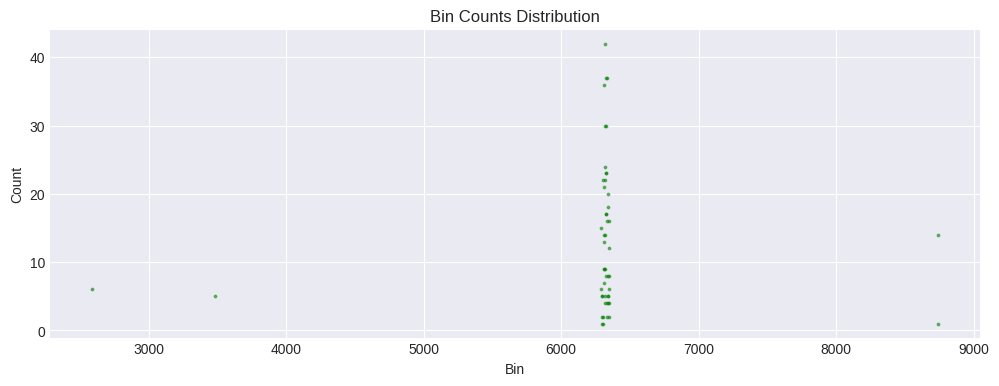

In [229]:
# Plotting
plt.style.use('seaborn-v0_8-darkgrid')  # Example style, replace with your preferred style
fig, ax = plt.subplots(figsize=(12, 4))

# Assuming bin_counts index is what you want on the x-axis and the values are what you want on the y-axis
ax.scatter(bin_counts.index, bin_counts.values, s=3, alpha=0.5, color='green')  # s controls the marker size, alpha controls transparency

ax.set_xlabel('Bin')  # Assuming 'Bin' is the appropriate label
ax.set_ylabel('Count')
ax.set_title('Bin Counts Distribution')

plt.show()